In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import seaborn as sns


In [114]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32

train_dir = r"C:\Users\himan\Downloads\archive (7)\Rice_Leaf_Diease\Rice_Leaf_Diease\train"
test_dir = r"C:\Users\himan\Downloads\archive (7)\Rice_Leaf_Diease\Rice_Leaf_Diease\test"

classes = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast',
           'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa',
           'sheath_blight', 'tungro']

train_datagen = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="sparse",
    subset="training",
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="sparse",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="sparse",
    shuffle=False

)



Found 12020 images belonging to 10 classes.
Found 3003 images belonging to 10 classes.
Found 3422 images belonging to 10 classes.


In [116]:
print("Class indices mapping:", train_generator.class_indices)

Class indices mapping: {'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5, 'neck_blast': 6, 'rice_hispa': 7, 'sheath_blight': 8, 'tungro': 9}


In [118]:
print("Training classes:")
print(train_generator.class_indices)

print("\nTest classes:")
print(test_generator.class_indices)

Training classes:
{'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5, 'neck_blast': 6, 'rice_hispa': 7, 'sheath_blight': 8, 'tungro': 9}

Test classes:
{'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5, 'neck_blast': 6, 'rice_hispa': 7, 'sheath_blight': 8, 'tungro': 9}


In [120]:
num_classes = len(train_generator.class_indices)

In [122]:

  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  for layer in base_model.layers[-50:]:
        layer.trainable = True
  for layer in base_model.layers[:-50]:
        layer.trainable = False

  model = keras.Sequential([

      keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      base_model,
      keras.layers.BatchNormalization(),

      keras.layers.GlobalAveragePooling2D(),
      #keras.layers.BatchNormalization(),
      #keras.layers.Dropout(0.4),

      keras.layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001),use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005),use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.4),

      keras.layers.Dense(num_classes, activation='softmax')

  ])


In [123]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [126]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [128]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(generator):
    labels = []
    for _, y_batch in generator:
        labels.extend(y_batch)
        if len(labels) >= generator.samples:
            break
    labels = np.array(labels, dtype=int)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

class_weights = calculate_class_weights(train_generator)

In [129]:
history = model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=callbacks,class_weight=class_weights)

import pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

C:\Users\himan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1645s 4s/step - accuracy: 0.5209 - loss: 2.5685 - val_accuracy: 0.8928 - val_loss: 1.2961 - learning_rate: 1.0000e-04
Epoch 2/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1783s 5s/step - accuracy: 0.8623 - loss: 1.4002 - val_accuracy: 0.9441 - val_loss: 1.1209 - learning_rate: 1.0000e-04
Epoch 3/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1943s 5s/step - accuracy: 0.9162 - loss: 1.1919 - val_accuracy: 0.9630 - val_loss: 1.0540 - learning_rate: 1.0000e-04
Epoch 4/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1500s 4s/step - accuracy: 0.9413 - loss: 1.1087 - val_accuracy: 0.9694 - val_loss: 0.9965 - learning_rate: 1.0000e-04
Epoch 5/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1449s 4s/step - accuracy: 0.9540 - loss: 1.0289 - val_accuracy: 0.9704 - val_loss: 0.9614 - learning_rate: 1.0000e-04
Epoch 6/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1450s 4s/step - accuracy: 0.9656 - loss: 0.9622 - val_accuracy: 0.9734 - val_loss: 0.9036 - learning_rate: 1.0000e-04
Epoch 7/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 1447s 4s/ste

In [132]:
model.save('rice_disease_model.keras') 
model.save_weights('rice_disease_weights.weights.h5') 

In [138]:
with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

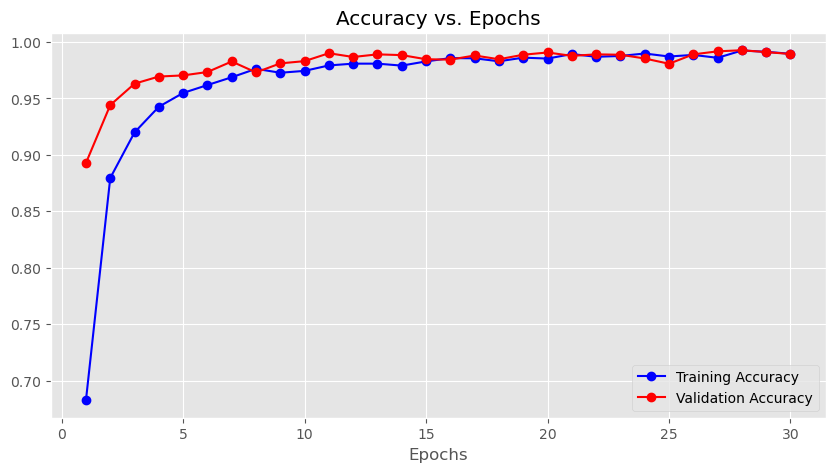

In [365]:
plt.figure(figsize=(10,5))

train_acc = history['accuracy']
val_acc = history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'o-', color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, 'o-', color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.title("Accuracy vs. Epochs")
plt.legend()

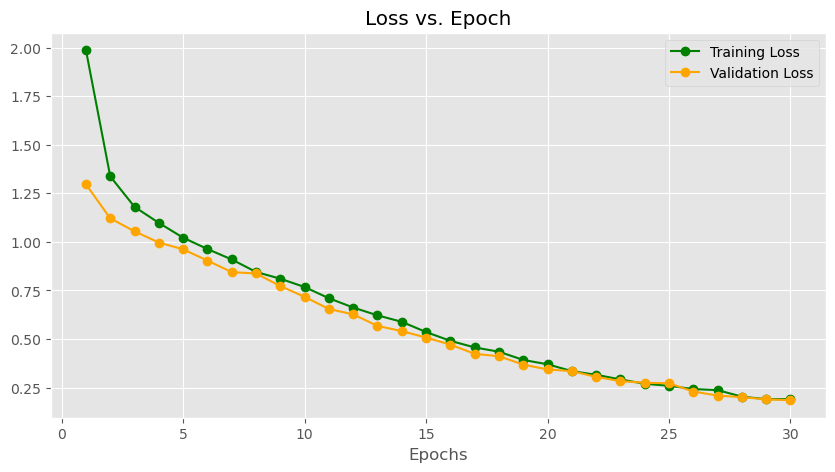

In [367]:
plt.figure(figsize=(10,5))
train_loss = history['loss']
val_loss = history['val_loss']

plt.plot(epochs, train_loss, 'o-', color='green', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss')
plt.xlabel("Epochs")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

Text(15, 0.21016156673431396, 'Validation Accuracy - Training Accuracy')

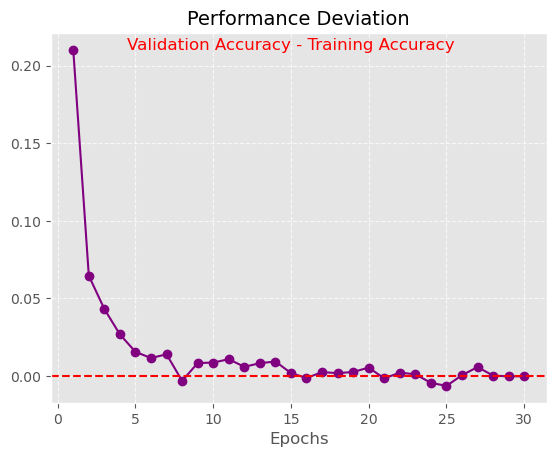

In [379]:
train_acc = history['accuracy']
val_acc = history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
performance_deviation = np.array(val_acc) - np.array(train_acc)
plt.plot(epochs, performance_deviation, 'o-', color='purple')
plt.title('Performance Deviation', fontsize=14)
plt.xlabel('Epochs', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')

plt.text(15, max(performance_deviation), 'Validation Accuracy - Training Accuracy', horizontalalignment='center', fontsize=12, color='red')


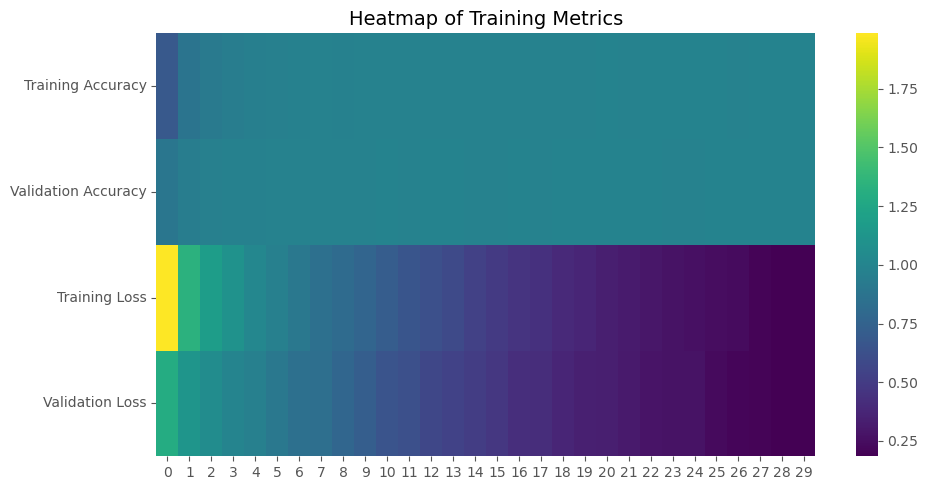

In [391]:
plt.figure(figsize=(10, 5))
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']
metrics_df = pd.DataFrame({
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Training Loss': train_loss,
    'Validation Loss': val_loss
})
sns.heatmap(metrics_df.transpose(), cmap='viridis', annot=False)
plt.title('Heatmap of Training Metrics', fontsize=14)
plt.tight_layout()
plt.show()

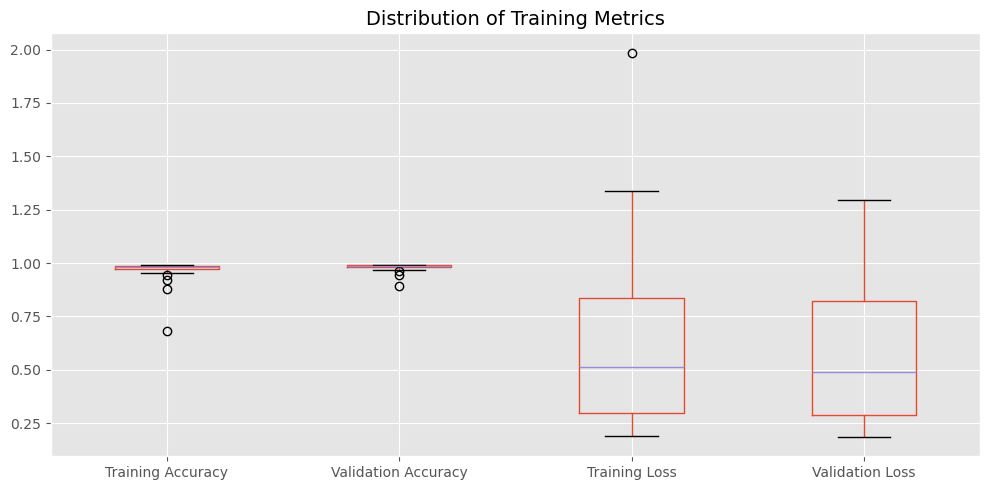

In [395]:
plt.figure(figsize=(10, 5))
metrics_df = pd.DataFrame({
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Training Loss': train_loss,
    'Validation Loss': val_loss
})
metrics_df.boxplot()
plt.title('Distribution of Training Metrics', fontsize=14)

plt.tight_layout()
plt.show()

In [288]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss:  {test_loss:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9954 - loss: 0.1658
Test accuracy: 99.53%
Test loss:  0.1674


In [282]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
print(classification_report(test_generator.classes, y_pred))

107/107 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       376
           1       0.99      0.99      0.99       380
           2       0.99      0.99      0.99       391
           3       0.99      0.99      0.99       362
           4       1.00      1.00      1.00       386
           5       0.99      0.99      0.99       382
           6       1.00      1.00      1.00       322
           7       1.00      0.99      0.99       225
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       310

    accuracy                           1.00      3422
   macro avg       1.00      1.00      1.00      3422
weighted avg       1.00      1.00      1.00      3422



In [319]:
cm = confusion_matrix(test_generator.classes, y_pred)
print("Confusion Matrix:-")
print(cm)


Confusion Matrix:-
[[376   0   0   0   0   0   0   0   0   0]
 [  0 377   0   2   0   1   0   0   0   0]
 [  0   1 388   2   0   0   0   0   0   0]
 [  1   1   0 358   0   2   0   0   0   0]
 [  0   0   0   0 386   0   0   0   0   0]
 [  1   0   0   0   1 379   0   0   1   0]
 [  0   0   0   0   0   0 322   0   0   0]
 [  0   0   3   0   0   0   0 222   0   0]
 [  0   0   0   0   0   0   0   0 288   0]
 [  0   0   0   0   0   0   0   0   0 310]]
